---
title: "Data Cleaning, Bagged trees & Random forest Code"
subtitle: Anaconda 
author: Kiara Villalobos-Hernandez
date: 06/07/2023
number-sections: true
abstract: This file contains the Data Preparation, Bagged Trees and Gradient Boost Code for the project on AMEX Default, as part of the STAT303-3 course in Spring 2023.
format: 
  html:
    toc: true
    toc-title: Contents
    self-contained: true
    font-size: 100%
    toc-depth: 4
    mainfont: serif

execute: 
    warning: false
    error: false
    
jupyter: python3

---

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split, cross_val_predict
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid, RandomizedSearchCV
from sklearn.ensemble import BaggingRegressor,BaggingClassifier,RandomForestClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, \
accuracy_score, precision_score, confusion_matrix, mean_squared_error, r2_score
from sklearn.impute import KNNImputer
from pyearth import Earth
import time as time

# Data Cleaning
*By Kiara Villalobos-Hernandez and Hoda Fakhari* 

In [2]:
train = pd.read_csv('train_subset.csv')

In [3]:
test = pd.read_csv('test_subset.csv')

In [4]:
y = pd.read_csv('train_labels.csv')

In [5]:
# merge response + predictors
train = pd.merge(train, y)
test = pd.merge(test, y)

In [6]:
train_filtered = train.drop(['Unnamed: 0','customer_ID','S_2','D_63','D_64'],axis=1)

In [7]:
test_filtered = test.drop(['Unnamed: 0','customer_ID','S_2','D_63','D_64'],axis=1)

In [8]:
# storing missing values for each column in train
val_train = train_filtered.isna().sum()

# storing missing values for each column in test
val_test = test_filtered.isna().sum()

In [152]:
# creating dataframe to store how many values are missing in each column for both train and test
na_df = pd.DataFrame(columns = train_filtered.columns)
test_na_df = pd.DataFrame(columns = test_filtered.columns)
test_na_df.loc['Train'] = val_train
test_na_df.loc['Test'] = val_test
na_df.loc['Train'] = val_train
na_df.loc['Test'] = val_test

In [155]:
# identify predictors with large number of missing values 
col_missing = []
for col in na_df.columns:
    if na_df.loc['Train',col]/10000 > .8:
        col_missing.append(col)

In [156]:
# identify predictors with large number of missing values 
test_col_missing = []
for col in test_na_df.columns:
    if test_na_df.loc['Train',col]/10000 > .8:
        test_col_missing.append(col)

In [157]:
# drop predictors with more than 80% missing values
train_filtered = train_filtered.drop(col_missing,axis=1)

In [160]:
test_filtered = test_filtered.drop(test_col_missing,axis=1)

In [162]:
imputer = KNNImputer(n_neighbors=1)

In [163]:
train_filtered = pd.DataFrame(imputer.fit_transform(train_filtered),columns = train_filtered.columns)

In [164]:
test_filtered = pd.DataFrame(imputer.fit_transform(test_filtered),columns = test_filtered.columns)

In [167]:
train_filtered.to_csv('train_clean.csv')

In [168]:
test_filtered.to_csv('test_clean.csv')

In [196]:
test_filtered

P_2      D_39       B_1       B_2       R_1       S_3      D_41  \
0     0.910519  0.003323  0.002007  0.813010  0.000483  0.164135  0.008578   
1     0.916596  0.002949  0.007152  0.810892  0.007676  0.164135  0.004424   
2     0.913374  0.000478  0.002182  0.815958  0.000189  0.164135  0.003844   
3     0.907133  0.009843  0.009453  0.819477  0.008656  0.164135  0.001826   
4     0.871219  0.009839  0.000488  0.814127  0.003975  0.164135  0.002952   
...        ...       ...       ...       ...       ...       ...       ...   
9995  0.923459  0.038349  0.034290  1.007538  0.003336  0.074092  0.000943   
9996  0.968773  0.682007  0.033532  1.004179  0.005582  0.068700  0.001663   
9997  0.994103  0.237832  0.028541  1.008582  0.002640  0.055308  0.004520   
9998  0.971680  0.802516  0.037812  1.007390  0.006115  0.026462  0.007735   
9999  0.990912  0.009236  0.019213  1.002660  0.005935 -0.035923  0.007416   

           B_3      D_43      D_44  ...     D_131     D_133      R_28  \
0     0.005668  0.015702  0.002834  ...  0.001487  0.008845  0.003424   
1     0.007180  0.015702  0.002115  ...  0.000661  0.001575  0.004340   
2     0.006892  0.015702  0.005679  ...  0.007952  0.001629  0.006936   
3     0.000576  0.015702  0.004294  ...  0.005089  0.000058  0.000533   
4     0.001971  0.015702  0.003254  ...  0.007130  0.005932  0.004834   
...        ...       ...       ...  ...       ...       ...       ...   
9995  0.009005  0.035222  0.002907  ...  0.008891  0.000086  0.000409   
9996  0.002438  0.034049  0.007320  ...  0.004538  0.005462  0.001390   
9997  0.005361  0.031825  0.009472  ...  0.000662  0.003891  0.004251   
9998  0.003908  0.031825  0.001587  ...  0.004761  0.006838  0.009980   
9999  0.007344  0.031825  0.005237  ...  0.001046  0.003594  0.004140   

         D_139     D_140     D_141     D_143     D_144     D_145  target  
0     0.005055  0.003387  0.006381  0.009071  0.000452  0.009093     0.0  
1     0.009045  0.005062  0.008398  0.009962  0.009318  0.003389     0.0  
2     0.002448  0.006637  0.002498  0.002704  0.009881  0.006629     0.0  
3     0.008992  0.002036  0.000650  0.007807  0.007089  0.009498     0.0  
4     0.000094  0.006466  0.006941  0.000021  0.009241  0.008565     0.0  
...        ...       ...       ...       ...       ...       ...     ...  
9995  0.007934  0.005344  0.006785  0.002709  0.005027  0.008763     0.0  
9996  0.000122  0.002820  0.002444  0.006658  0.003938  0.005537     0.0  
9997  0.001989  0.006962  0.000827  0.003828  0.008829  0.000494     0.0  
9998  0.004796  0.005723  0.002804  0.004543  0.004120  0.000063     0.0  
9999  0.003087  0.009291  0.008839  0.000551  0.006786  0.007417     0.0  

[10000 rows x 164 columns]

# Tuning Decision Tree Classifier
*By Kiara Villalobos-Hernandez*

In [12]:
# building model
model = DecisionTreeClassifier(random_state=1).fit(X_train, y_train)

In [13]:
pred = model.predict(X_test)

In [15]:
print("Maximum tree depth =", model.get_depth())

print("Maximum leaves =", model.get_n_leaves())

Maximum tree depth = 25
Maximum leaves = 328


In [20]:
param_grid = {'max_depth':range(2,25,5),
              'max_leaf_nodes':range(2,50), 
              'max_features':range(1,20)}

skf = StratifiedKFold(n_splits=5)

# grid search to find optimal parameter values
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=45), param_grid,
                           scoring=['recall', 'accuracy'], 
                           refit="recall", cv=skf, n_jobs=-1, verbose = True)
grid_search.fit(X_train, y_train)

print('Best params for recall')
print(grid_search.best_params_)


Fitting 5 folds for each of 4560 candidates, totalling 22800 fits
Best params for recall
{'max_depth': 2, 'max_features': 5, 'max_leaf_nodes': 2}


In [24]:
# fitting model w/ optimal parameter values
classmodel = DecisionTreeClassifier(random_state=1, max_depth = 2, max_leaf_nodes=2,
                                    max_features=5).fit(X_train, y_train)

cross_val_ypred = cross_val_predict(DecisionTreeClassifier(random_state=1, max_depth = 2, 
                                                        max_leaf_nodes=2, max_features=5), X_train, 
                                              y_train, cv = 5, method = 'predict_proba')

# data underlying accuracy/recall/threshold plot
metrics = pd.DataFrame()
i = 0
threshold_hyperparam = np.arange(0, 1.01, 0.001)

for threshold in threshold_hyperparam:
  predicted = cross_val_ypred[:, 1] > threshold
  predicted = predicted.astype(int)

  accuracy = accuracy_score(predicted, y_train)*100
  metrics.loc[i, 'threshold'] = threshold
  metrics.loc[i, 'accuracy'] = accuracy
  metrics.loc[i, 'recall'] = recall_score(y_train, predicted)*100
  
  i = i + 1

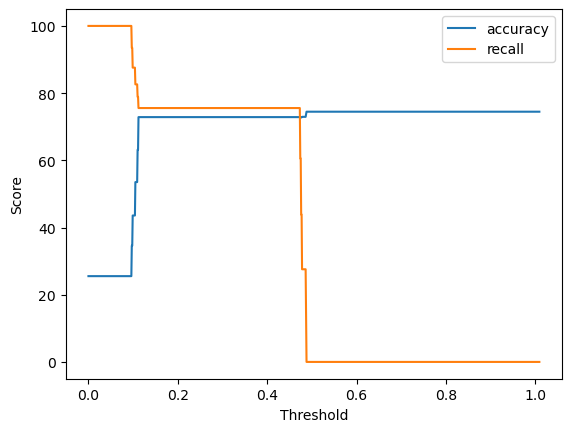

In [25]:
# plotting accuracy, recall, against threshold
plt.plot(metrics.threshold,metrics.accuracy, label = "accuracy")
plt.plot(metrics.threshold,metrics.recall, label = "recall")
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()

In [39]:
# finding optimal threshold
metrics.loc[(metrics.accuracy>=72.0) & (metrics.recall>=75.0), :].sort_values(by = 'recall',
                                                                              ascending = False).iloc[0,:]

threshold     0.112000
accuracy     72.860000
recall       75.558167
Name: 112, dtype: float64

In [40]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.112

y_pred_prob = classmodel.predict_proba(X_train)[:,1] 

# Classifying observations uaing desired threshold
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the train accuracy
print("Train Accuracy: ",accuracy_score(y_pred, y_train)*100)  

#Computing train recall
print("Train Recall: ", recall_score(y_train, y_pred)*100)

# resetting predictions
y_pred_prob = classmodel.predict_proba(X_test)[:,1] 

# Classifying observations using desired threshold
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the test accuracy
print("Test Accuracy: ",accuracy_score(y_pred, y_test)*100)  

#Computing the test recall
print("Test Recall: ", recall_score(y_test, y_pred)*100)

Train Accuracy:  72.87
Train Recall:  75.5973364669017
Test Accuracy:  77.09
Test Recall:  79.6622097114708


# BaggingClassifier w/ Tuned Decision Tree Classifier
*By Kiara Villalobos-Hernandez*

In [47]:
bag_model = BaggingClassifier(classmodel, n_estimators=50, random_state=1,
                        n_jobs=-1, oob_score=True).fit(X_train, y_train)

In [48]:
ypred = bag_model.predict_proba(X_train)[:,1]

In [50]:
cross_val_ypred = cross_val_predict(BaggingClassifier(classmodel, n_estimators=50, random_state=1,
                        n_jobs=-1, oob_score=True), X_train, 
                                              y_train, cv = 5, method = 'predict_proba')



# data underlying accuracy/recall/threshold plot
metrics = pd.DataFrame()
i = 0
threshold_hyperparam = np.arange(0, 1.01, 0.001)

for threshold in threshold_hyperparam:
  predicted = cross_val_ypred[:, 1] > threshold
  predicted = predicted.astype(int)

  accuracy = accuracy_score(predicted, y_train)*100
  metrics.loc[i, 'threshold'] = threshold
  metrics.loc[i, 'accuracy'] = accuracy
  metrics.loc[i, 'recall'] = recall_score(y_train, predicted)*100
  
  i = i + 1

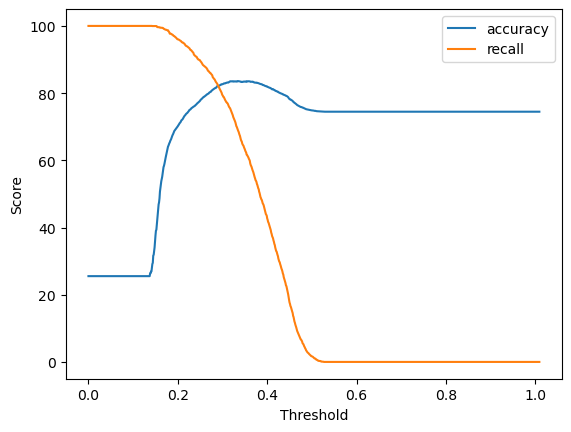

In [51]:
# plotting accuracy, recall, against threshold
plt.plot(metrics.threshold,metrics.accuracy, label = "accuracy")
plt.plot(metrics.threshold,metrics.recall, label = "recall")
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()

In [64]:
# finding optimal threshold
metrics.loc[(metrics.accuracy>=82.0) & (metrics.recall>=82.0), :].sort_values(by = 'recall',
                                                                              ascending = False).iloc[0,:]

threshold     0.288000
accuracy     82.050000
recall       82.804544
Name: 288, dtype: float64

In [90]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.288

y_pred_prob = bag_model.predict_proba(X_train)[:,1] 

# Classifying observations uaing desired threshold
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the train accuracy
print("Train Accuracy: ",accuracy_score(y_pred, y_train)*100)  

#Computing train recall
print("Train Recall: ", recall_score(y_train, y_pred)*100)

# resetting predictions
y_pred_prob = bag_model.predict_proba(X_test)[:,1] 

# Classifying observations using desired threshold
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the test accuracy
print("Test Accuracy: ",accuracy_score(y_pred, y_test)*100)  

#Computing the test recall
print("Test Recall: ", recall_score(y_test, y_pred)*100)

Train Accuracy:  82.28999999999999
Train Recall:  84.37132784958872
Test Accuracy:  81.87
Test Recall:  81.31597466572836


# Tuning Bagging Classifier
*By Kiara Villalobos-Hernandez*

In [68]:
params = {'max_samples': [0.1,0.5,1.0],
          'max_features': [0.1,0.5,1.0],
          'bootstrap_features': [True, False]}

cv = KFold(n_splits=2,shuffle=True,random_state=1)
bagging_classifier_grid = GridSearchCV(BaggingClassifier(estimator = classmodel,
                                                         n_estimators=250, random_state=1, n_jobs=-1, bootstrap=True),
                                       param_grid =params, cv=cv, n_jobs=-1, verbose=1,
                                       scoring = ['accuracy', 'recall'], refit='recall')
bagging_classifier_grid.fit(X_train, y_train)

print('Train accuracy : %.3f'%bagging_classifier_grid.best_estimator_.score(X_train, y_train))
print('Test accuracy : %.3f'%bagging_classifier_grid.best_estimator_.score(X_test, y_test))
print('Best accuracy Through Grid Search : %.3f'%bagging_classifier_grid.best_score_)
print('Best Parameters : ',bagging_classifier_grid.best_params_)

Fitting 2 folds for each of 18 candidates, totalling 36 fits
Train accuracy : 0.753
Test accuracy : 0.727
Best accuracy Through Grid Search : 0.049
Best Parameters :  {'bootstrap_features': True, 'max_features': 0.5, 'max_samples': 0.1}


In [74]:
params = {'max_samples': [0.03,0.035,0.04],
          'max_features': [0.46,0.48,0.5],
          'bootstrap_features': [True, False]}

cv = KFold(n_splits=2,shuffle=True,random_state=1)
bagging_classifier_grid = GridSearchCV(BaggingClassifier(estimator = classmodel,
                                                         n_estimators=250, random_state=1, n_jobs=-1, bootstrap=True),
                                       param_grid =params, cv=cv, n_jobs=-1, verbose=1,
                                       scoring = ['accuracy', 'recall'], refit='recall')
bagging_classifier_grid.fit(X_train, y_train)

print('Train accuracy : %.3f'%bagging_classifier_grid.best_estimator_.score(X_train, y_train))
print('Test accuracy : %.3f'%bagging_classifier_grid.best_estimator_.score(X_test, y_test))
print('Best accuracy Through Grid Search : %.3f'%bagging_classifier_grid.best_score_)
print('Best Parameters : ',bagging_classifier_grid.best_params_)

Fitting 2 folds for each of 18 candidates, totalling 36 fits
Train accuracy : 0.757
Test accuracy : 0.730
Best accuracy Through Grid Search : 0.125
Best Parameters :  {'bootstrap_features': False, 'max_features': 0.48, 'max_samples': 0.035}


In [75]:
opt_bag_model = BaggingClassifier(classmodel, 
                                  n_estimators=250,
                                  random_state=1,
                                  n_jobs=-1,
                                  oob_score=True,
                                 bootstrap_features=False,
                                 max_features=0.48,
                                 max_samples=0.035).fit(X_train, y_train)

In [77]:
ypred = opt_bag_model.predict_proba(X_train)[:,1]

In [80]:
cross_val_ypred = cross_val_predict(BaggingClassifier(classmodel, 
                                  n_estimators=250,
                                  random_state=1,
                                  n_jobs=-1,
                                  oob_score=True,
                                 bootstrap_features=False,
                                 max_features=0.48,
                                 max_samples=0.035), X_train, 
                                              y_train, cv = 5, method = 'predict_proba')



# data underlying accuracy/recall/threshold plot
metrics = pd.DataFrame()
i = 0
threshold_hyperparam = np.arange(0, 1.01, 0.001)

for threshold in threshold_hyperparam:
  predicted = cross_val_ypred[:, 1] > threshold
  predicted = predicted.astype(int)

  accuracy = accuracy_score(predicted, y_train)*100
  metrics.loc[i, 'threshold'] = threshold
  metrics.loc[i, 'accuracy'] = accuracy
  metrics.loc[i, 'recall'] = recall_score(y_train, predicted)*100
  
  i = i + 1

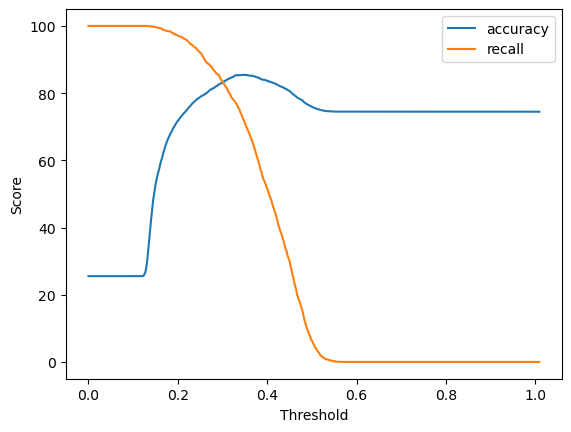

In [81]:
# plotting accuracy, recall, against threshold
plt.plot(metrics.threshold,metrics.accuracy, label = "accuracy")
plt.plot(metrics.threshold,metrics.recall, label = "recall")
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()

In [86]:
# finding optimal threshold
metrics.loc[(metrics.accuracy>=83.0) & (metrics.recall>=82.0), :].sort_values(by = 'recall',
                                                                              ascending = False).iloc[0,:]

threshold     0.299000
accuracy     83.090000
recall       83.705445
Name: 299, dtype: float64

In [89]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.299

y_pred_prob = opt_bag_model.predict_proba(X_train)[:,1] 

# Classifying observations uaing desired threshold
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the train accuracy
print("Train Accuracy: ",accuracy_score(y_pred, y_train)*100)  

#Computing train recall
print("Train Recall: ", recall_score(y_train, y_pred)*100)

# resetting predictions
y_pred_prob = opt_bag_model.predict_proba(X_test)[:,1] 

# Classifying observations using desired threshold
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the test accuracy
print("Test Accuracy: ",accuracy_score(y_pred, y_test)*100)  

#Computing the test recall
print("Test Recall: ", recall_score(y_test, y_pred)*100)

Train Accuracy:  83.67
Train Recall:  83.78378378378379
Test Accuracy:  83.47
Test Recall:  81.06966924700914


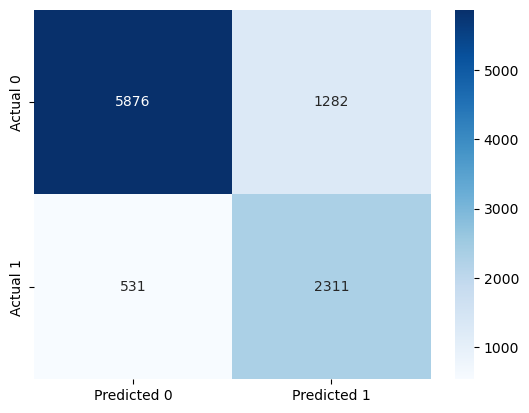

In [91]:
#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

# Random Forest
*By Kiara Villalobos-Hernandez*

In [11]:
# coarse grid search
parameters = {'max_depth':range(2,25, 5),
              'max_leaf_nodes':range(2,45,9),
              'max_features': range(1,20)}

skf = StratifiedKFold(n_splits=5)

forest_grid = RandomizedSearchCV(RandomForestClassifier(random_state=1), parameters, n_jobs=-1,verbose=True,cv=skf,
                    scoring=['recall', 'accuracy'], refit = 'recall', n_iter=20)

forest_grid.fit(X_train, y_train)

print (forest_grid.best_score_, forest_grid.best_params_) 

Fitting 5 folds for each of 20 candidates, totalling 100 fits
0.7136648632055561 {'max_leaf_nodes': 38, 'max_features': 15, 'max_depth': 22}


In [12]:
# coarse grid search
parameters = {'max_depth':range(18,26, 3),
              'max_leaf_nodes':range(2,40,9),
              'max_features': range(10,20)}

skf = StratifiedKFold(n_splits=5)

forest_grid = RandomizedSearchCV(RandomForestClassifier(random_state=1), parameters, n_jobs=-1,verbose=True,cv=skf,
                    scoring=['recall', 'accuracy'], refit = 'recall', n_iter=20)

forest_grid.fit(X_train, y_train)

print (forest_grid.best_score_, forest_grid.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
0.7113226660527225 {'max_leaf_nodes': 29, 'max_features': 17, 'max_depth': 24}


In [14]:
# coarse grid search
parameters = {'max_depth':range(20,25),
              'max_leaf_nodes':range(25,40,5),
              'max_features': range(15,20)}

skf = StratifiedKFold(n_splits=5)

forest_grid = RandomizedSearchCV(RandomForestClassifier(random_state=1), parameters, n_jobs=-1,verbose=True,cv=skf,
                    scoring=['recall', 'accuracy'], refit = 'recall', n_iter=50)

forest_grid.fit(X_train, y_train)

print (forest_grid.best_score_, forest_grid.best_params_) 

Fitting 5 folds for each of 50 candidates, totalling 250 fits
0.7211112390161544 {'max_leaf_nodes': 35, 'max_features': 19, 'max_depth': 20}


In [16]:
# coarse grid search
parameters = {'max_depth':range(20,24),
              'max_leaf_nodes':range(30,40,5),
              'max_features': range(15,20)}

skf = StratifiedKFold(n_splits=5)

forest_grid = GridSearchCV(RandomForestClassifier(random_state=1), parameters, n_jobs=-1,verbose=True,cv=skf,
                    scoring=['recall', 'accuracy'], refit = 'recall')

forest_grid.fit(X_train, y_train)

print (forest_grid.best_score_, forest_grid.best_params_) 

Fitting 5 folds for each of 40 candidates, totalling 200 fits
0.7211112390161544 {'max_depth': 20, 'max_features': 19, 'max_leaf_nodes': 35}


In [17]:
# coarse grid search
parameters = {'max_depth':[19,20,21],
              'max_leaf_nodes':[34,35,36],
              'max_features': [18,19,20]}

skf = StratifiedKFold(n_splits=5)

forest_grid = GridSearchCV(RandomForestClassifier(random_state=1), parameters, n_jobs=-1,verbose=True,cv=skf,
                    scoring=['recall', 'accuracy'], refit = 'recall')

forest_grid.fit(X_train, y_train)

print (forest_grid.best_score_, forest_grid.best_params_) 

Fitting 5 folds for each of 27 candidates, totalling 135 fits
0.7261993016384636 {'max_depth': 19, 'max_features': 20, 'max_leaf_nodes': 36}


In [19]:
# coarse grid search
parameters = {'max_depth':[17,18,19],
              'max_leaf_nodes':[36,37,38],
              'max_features': [19,20,21]}

skf = StratifiedKFold(n_splits=5)

forest_grid = GridSearchCV(RandomForestClassifier(random_state=1), parameters, n_jobs=-1,verbose=True,cv=skf,
                    scoring=['recall', 'accuracy'], refit = 'recall')

forest_grid.fit(X_train, y_train)

print (forest_grid.best_score_, forest_grid.best_params_) 

Fitting 5 folds for each of 27 candidates, totalling 135 fits
0.7293319519588658 {'max_depth': 17, 'max_features': 20, 'max_leaf_nodes': 37}


Text(0, 0.5, 'Accuracy')

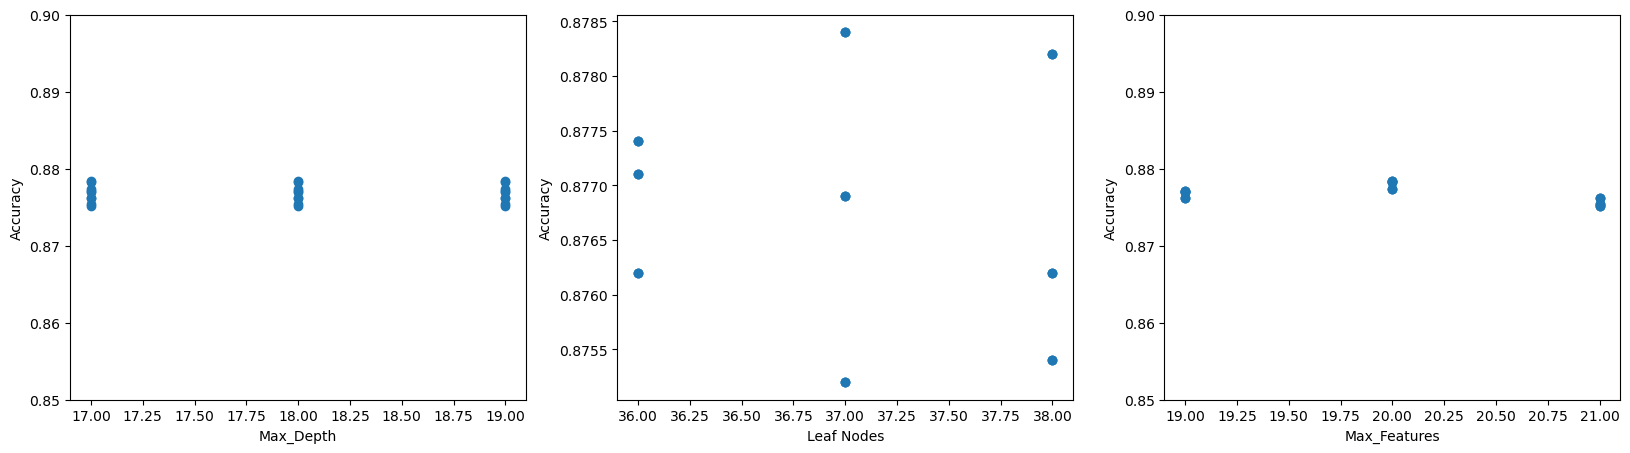

In [20]:
#Detailed results of k-fold cross validation
cv_results = pd.DataFrame(forest_grid.cv_results_)

fig, axes = plt.subplots(1,3,figsize=(20,5))
plt.subplots_adjust(wspace=0.2)

axes[0].plot(cv_results.param_max_depth, cv_results.mean_test_accuracy, 'o')
axes[0].set_ylim([0.85, 0.9])
axes[0].set_xlabel('Max_Depth')
axes[0].set_ylabel('Accuracy')

axes[1].plot(cv_results.param_max_leaf_nodes, cv_results.mean_test_accuracy, 'o')
axes[0].set_ylim([0.85, 0.9])
axes[1].set_xlabel('Leaf Nodes')
axes[1].set_ylabel('Accuracy')

axes[2].plot(cv_results.param_max_features, cv_results.mean_test_accuracy, 'o')
axes[2].set_ylim([0.85, 0.9])
axes[2].set_xlabel('Max_Features')
axes[2].set_ylabel('Accuracy')

In [21]:
# fitting model with optimal hyperparameter values
forestmodel = RandomForestClassifier(random_state=1, max_depth = 17, max_leaf_nodes=37,
                                      max_features=20).fit(X_train, y_train)

cross_val_ypred = cross_val_predict(RandomForestClassifier(random_state=1, max_depth = 17,
                                                           max_leaf_nodes=37, max_features=20), X_train,
                                    y_train, cv = 5, method = 'predict_proba')

# data underlying accuracy/recall/threshold plot
metrics = pd.DataFrame()
i = 0
threshold_hyperparam = np.arange(0, 1.01, 0.001)

for threshold in threshold_hyperparam:
  predicted = cross_val_ypred[:, 1] > threshold
  predicted = predicted.astype(int)

 # accuracy = accuracy_score(predicted, y_train)*100
  metrics.loc[i, 'threshold'] = threshold
  metrics.loc[i, 'accuracy'] = accuracy_score(y_train, predicted)*100
  metrics.loc[i, 'recall'] = recall_score(y_train, predicted)*100
  
  i = i + 1

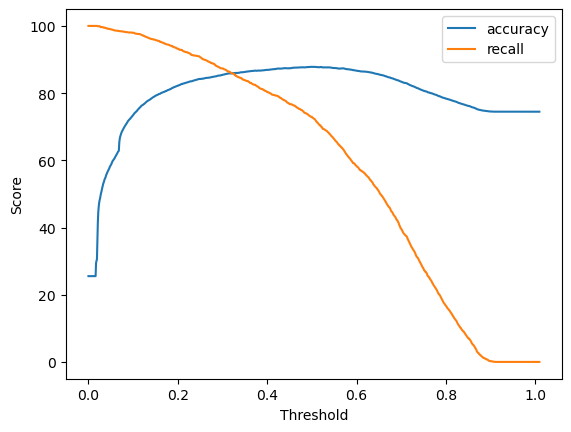

In [22]:
# plotting accuracy, recall, against threshold
plt.plot(metrics.threshold,metrics.accuracy, label = "accuracy")
plt.plot(metrics.threshold,metrics.recall, label = "recall")
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()

In [27]:
# finding optimal threshold
metrics.loc[(metrics.accuracy>=85.0) & (metrics.recall>=85.0), :].sort_values(by = 'recall',
                                                                              ascending = False).iloc[0,:]

threshold     0.285000
accuracy     85.010000
recall       88.209949
Name: 285, dtype: float64

In [28]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.285

y_pred_prob = forestmodel.predict_proba(X_train)[:,1] 

# Classifying observations uaing desired threshold
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the train accuracy
print("Train Accuracy: ",accuracy_score(y_pred, y_train)*100)  

#Computing train recall
print("Train Recall: ", recall_score(y_train, y_pred)*100)

# resetting predictions
y_pred_prob = forestmodel.predict_proba(X_test)[:,1] 

# Classifying observations using desired threshold
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the test accuracy
print("Test Accuracy: ",accuracy_score(y_pred, y_test)*100)  

#Computing the test recall
print("Test Recall: ", recall_score(y_test, y_pred)*100)

Train Accuracy:  91.21000000000001
Train Recall:  95.53466509988249
Test Accuracy:  84.82
Test Recall:  85.08092892329346


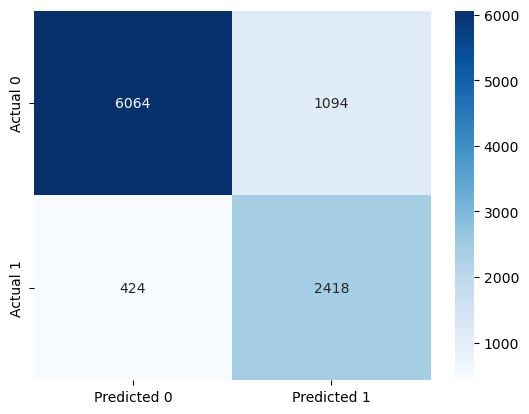

In [29]:
#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');